<a href="https://colab.research.google.com/github/Karnak123/youtube-adview-prediction/blob/main/youtbe_adview_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import relevant libraries

In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from google.colab import files

# Read csv

Manually upload file after downloading from https://drive.google.com/file/d/1Dv-HF10AUUA03AO_cQvar462eXawk0iQ/view

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D
...,...,...,...,...,...,...,...,...,...
14994,VID_31,2,525949,1137,83,86,2015-05-18,PT6M10S,A
14995,VID_5861,1,665673,3849,156,569,2015-10-20,PT3M56S,D
14996,VID_805,4,3479,16,1,1,2013-08-23,PT3M13S,B
14997,VID_19843,1,963,0,0,0,2010-10-02,PT26S,G


In [4]:
test

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B
...,...,...,...,...,...,...,...,...
8759,VID_2944,111205,471,14,101,2011-04-19,PT3M14S,C
8760,VID_8195,1074457,1024,195,65,2016-06-03,PT2H18M35S,D
8761,VID_18973,1891692,4606,1109,191,2016-06-26,PT7M14S,F
8762,VID_5849,714859,1639,151,382,2016-03-23,PT3M15S,D


# Preprocessing

In [5]:
categories = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}

data["category"] = data["category"].map(categories)
test["category"] = test["category"].map(categories)

In [6]:
for e in ["views", "likes", "dislikes", "comment"]:
    data = data[data[e] != "F"]
    for i in range(len(test)):
        if test[e][i]=='F':
            test.loc[i, e] = '0'

for e in ["views", "likes", "dislikes", "comment", "adview"]:
    data[e] = pd.to_numeric(data[e])
    if e != 'adview':
        test[e] = pd.to_numeric(test[e])

data = data[data["adview"] < 2000000]

data["published"] = LabelEncoder().fit_transform(data["published"])
test["published"] = LabelEncoder().fit_transform(test["published"])

In [7]:
def checki(x):
    y = x[2:]
    h, m, s, mm = "", "", "", ""
    P = ["H", "M", "S"]
    for i in y:
        if i not in P:
            mm += i
        else:
            if i == P[0]:
                h = mm
                mm = ""
            elif i == P[1]:
                m = mm
                mm = ""
            else:
                s = mm
                mm = ""
    if h == "":
        h = "00"
    if m == "":
        m = "00"
    if s == "":
        s = "00"
    bp = h + ":" + m + ":" + s
    return bp

In [8]:
def func_sec(time_str):
    h, m, s = time_str.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

In [9]:
data["duration"] = data["duration"].apply(checki).apply(func_sec)
test["duration"] = test["duration"].apply(checki).apply(func_sec)

# Visualize correlation

[]

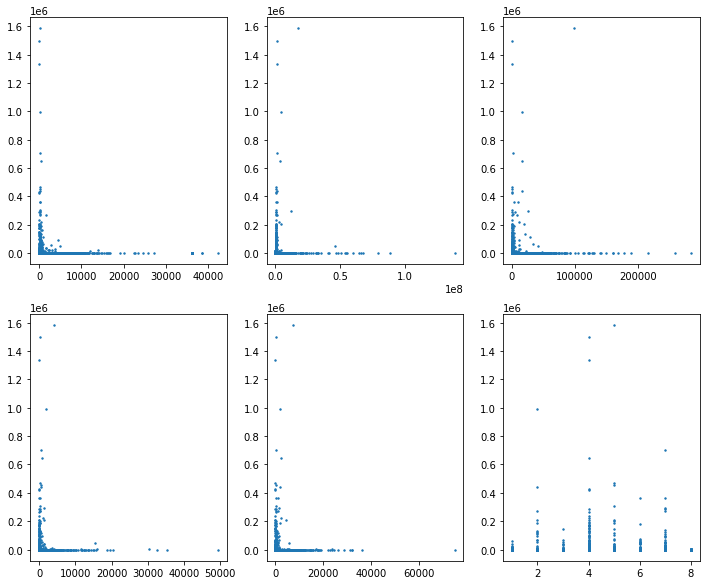

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
axs[0, 0].scatter(data["duration"], data["adview"], s=2)
axs[0, 1].scatter(data["views"], data["adview"], s=2)
axs[0, 2].scatter(data["likes"], data["adview"], s=2)
axs[1, 0].scatter(data["dislikes"], data["adview"], s=2)
axs[1, 1].scatter(data["comment"], data["adview"], s=2)
axs[1, 2].scatter(data["category"], data["adview"], s=2)
plt.plot()

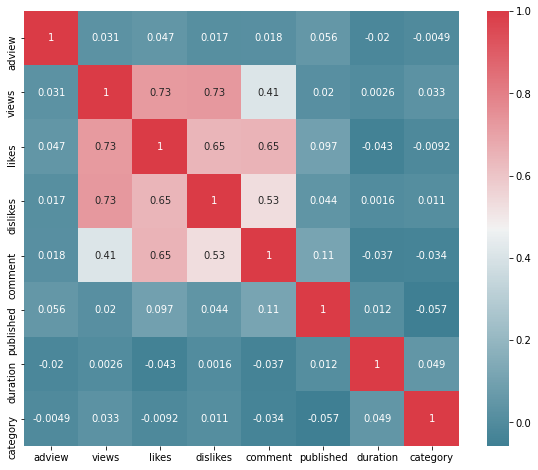

In [18]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
square=True, ax=ax,annot=True)
plt.show()

# Prepare for input to model

In [19]:
Y = pd.DataFrame(data.iloc[:, 1].values, columns=["target"])
test_y = pd.DataFrame(test.iloc[:, 0].values, columns=['vidid'])
data = data.drop(["adview", "vidid"], axis=1)
test = test.drop(['vidid'], axis=1)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    data, Y, test_size=0.1, random_state=42
)
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

In [21]:
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)
test = sc_X.transform(test)

# Test on models

In [23]:
def evaluate(X_val, y_val, model):
    y_preds = model.predict(X_val)
    print("RMSE : ", np.sqrt(mean_squared_error(y_val, y_preds)))
    print("R^2 : ", r2_score(y_val, y_preds))
    plt.figure(figsize=(16, 8))
    plt.scatter(range(len(y_preds)), y_preds, color='blue', s=1)
    plt.scatter(range(len(y_val)), y_val, color='red', s=1)
    plt.show()

### Linear Regression

Lineasr Regression
RMSE :  10237.05145626168
R^2 :  -0.022721187595377


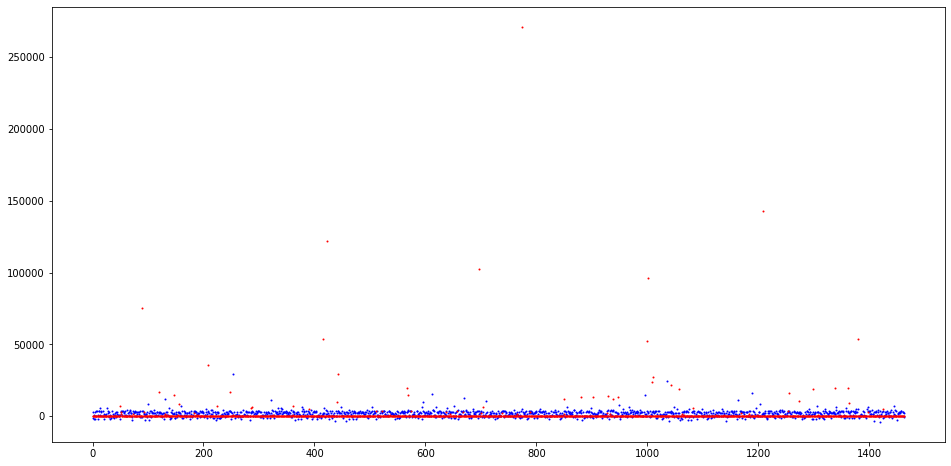

In [25]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
print("Lineasr Regression")
evaluate(X_val, y_val, linear_regression)

### SVR

SVR
RMSE :  10176.569923886505
R^2 :  -0.010672206520453864


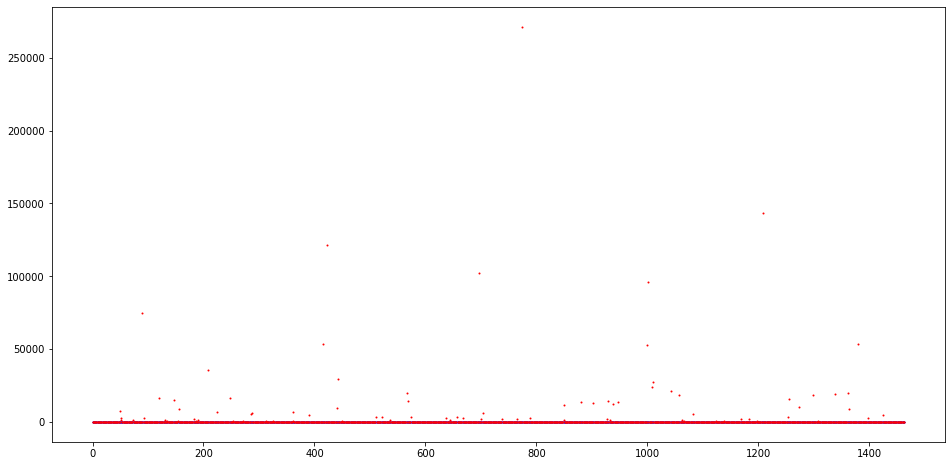

In [27]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
print("SVR")
evaluate(X_val, y_val, svr_model)

### Decision Tree

Decision Tree
RMSE :  14639.515852869616
R^2 :  -1.0915146422986752


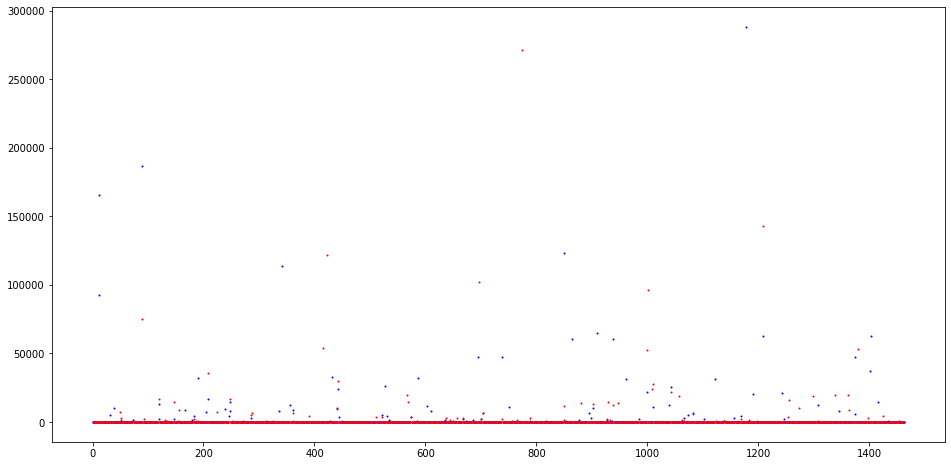

In [29]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
print("Decision Tree")
evaluate(X_val, y_val, dt_model)

### Random Forest

Random Forest
RMSE :  13588.090380743266
R^2 :  -0.8018736508410664


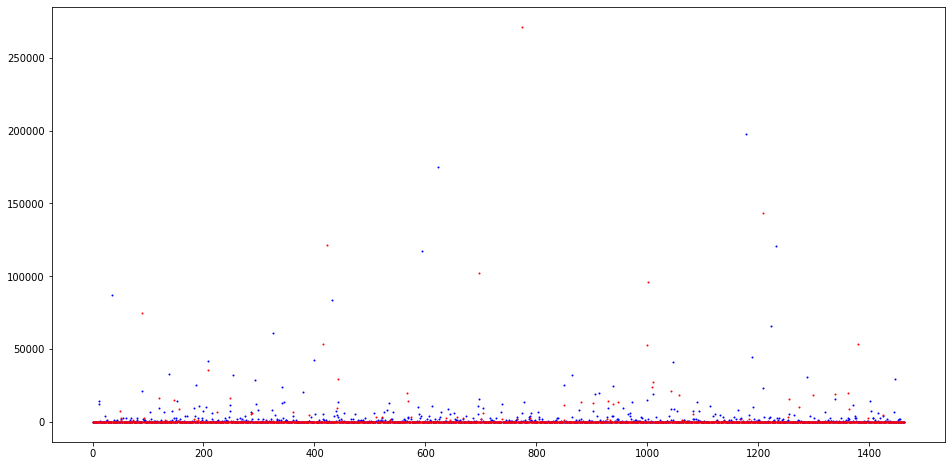

In [39]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
print("Random Forest")
evaluate(X_val, y_val, rf_model)

### Random Forest w/ Hyperparameter tuning

In [40]:
n_estimators = [int(x) for x in np.linspace(50, 300, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 60, num = 3)]
min_samples_split = [5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.5min finished


RMSE :  11350.92653211989
R^2 :  -0.2573903015572061


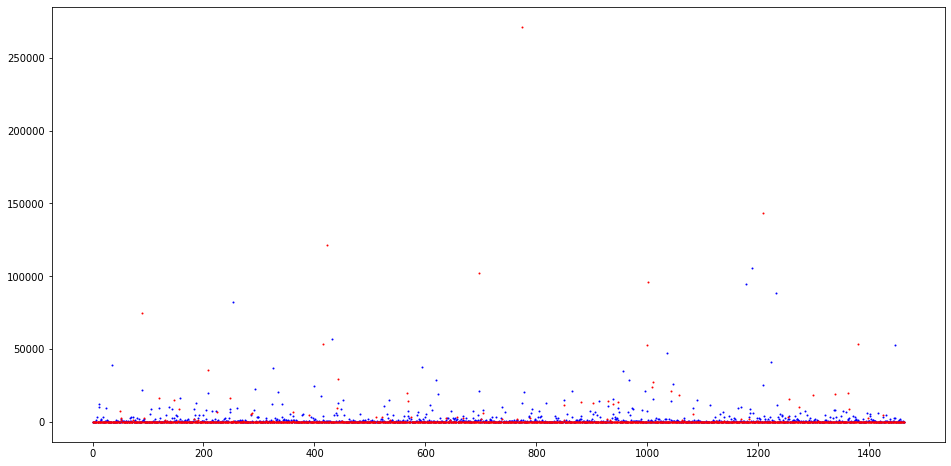

In [42]:
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions = random_grid, n_iter = 15, cv = 10, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_random.fit(X_train, y_train)
evaluate(X_val, y_val, rf_random.best_estimator_)

### Neural Network

In [46]:
nn_model = keras.models.Sequential([
                keras.layers.Dense(16, input_shape=(7,), activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(16, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(8, activation='relu'),
                keras.layers.Dense(units=1)
])

In [47]:
nn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

RMSE :  10056.72095865373
R^2 :  0.012992890791327927


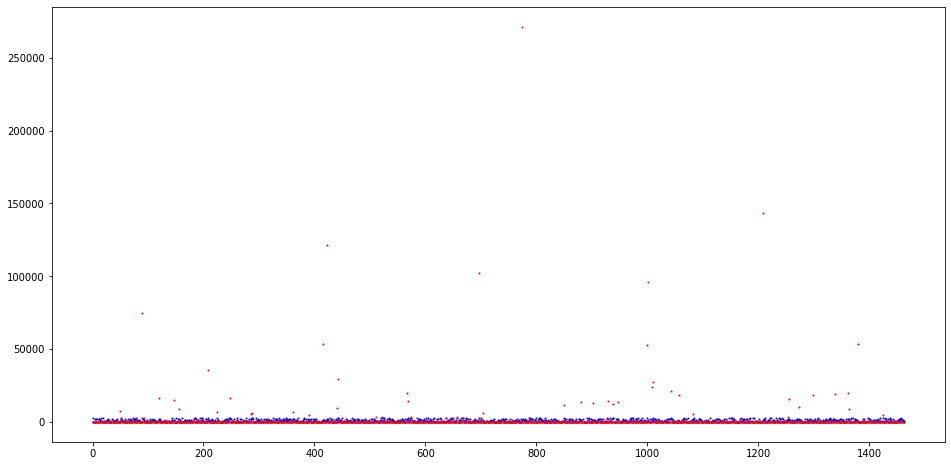

In [48]:
nn_model.fit(X_train, y_train, epochs=200, verbose=0)
evaluate(X_val, y_val, nn_model)

# Save model

In [49]:
joblib.dump(rf_random.best_estimator_, "ml_model.pkl")

['ml_model.pkl']

In [50]:
nn_model.save('nn_model.h5')

# Load model

In [51]:
model = joblib.load('ml_model.pkl')

In [52]:
model = keras.models.load_model('nn_model.h5')

In [56]:
preds = model.predict(test)

In [57]:
preds = preds.tolist()
d = {'adview': preds}
pd.DataFrame(d).to_csv('predictions.csv', index=False)